In [1]:
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import sys
# sys.path.append(os.path.dirname(sys.path[0]))
import torch
import numpy as np
import json

from pathlib import Path
import torch.nn.functional as F


In [2]:
print(torch.__version__)
torch.cuda.is_available()

2.4.1+cu121


True

In [4]:
import yaml
# from hw2vec.hw2vec.config import Config
from hw2vec.hw2vec.hw2graph import *
from hw2vec.hw2vec.graph2vec.models import *
# Define a class to encapsulate the configuration dictionary
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)

# Configuration parameters
yaml_path = 'hw2vec/examples/example_gnn4tj.yaml'
# raw_dataset_path = Path('../assets/testing')
# raw_dataset_path = Path('../../AES-T100/src/TjIn') 
# raw_dataset_path = Path('../../RS232-T100/src/') 
# raw_dataset_path = Path('../../PIC16F84-T200/src/TjIn') xmitH
# raw_dataset_path = Path('../../b15-T100/src/TjIn') 
# raw_dataset_path = Path('../../s15850-T100/src/TjIn') 
# raw_dataset_path = Path('../../ISCAS85/test2') 

# raw_dataset_path = Path('/home/easha/FYP/B15-seriesprocessed/B15-series/TjFree/b15-T400') 
# raw_dataset_path = Path('/home/easha/FYP/PIC16F84-T100/src/TjIn') 
raw_dataset_path = Path('/home/easha/FYP/hw2vec/assets/datasets/TJ-RTL-toy/TjFree/xtea') 
# raw_dataset_path = Path('/home/easha/FYP/S-seriespreprocessednew/S-series/TjIn/s15850-T100') 




# verilog_file_path = Path('../../test2') 
verilog_file_path = raw_dataset_path

# raw_dataset_path = Path('../../VerilogTest') 

data_pkl_path = Path('hw2vec/examples/testing.pkl')
graph_type = 'DFG'
device = 'cuda'

with open(yaml_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update config_dict with additional parameters
config_dict.update({
    'raw_dataset_path': str(raw_dataset_path),
    'data_pkl_path': str(data_pkl_path),
    'graph_type': graph_type,
    'device': device
})

# Initialize the configuration class
config = Config(config_dict)

# verilog path file already set

nx_graphs = []
hw2graph = HW2GRAPH(config)

# Process the single Verilog file
hw_graph = hw2graph.code2graph(verilog_file_path)
nx_graphs.append(hw_graph)

data_proc = DataProcessor(config)
for hw_graph in nx_graphs:
    data_proc.process(hw_graph)
data_proc.cache_graph_data(config.data_pkl_path)
data=data_proc.get_graphs()

# model_path = "model_trained.pth"xmitH
# model_path = "/home/easha/FYP/hw2vec/assets/pretrained_DFG_TJ_RTL/model.pth"
# model_path = "hw2vec/assets/pretrained_DFG_TJ_RTL/model.pth"
# model_path = "MustafaModels/Models/gin/Combined_Dataset/400_0.001.pth"
model_path = "trained_models/DOS_copy_model.pth"


# config_path =  "model_trained.cfg"
# config_path = "/home/easha/FYP/hw2vec/assets/pretrained_DFG_TJ_RTL/model.cfg"
# config_path = "MustafaModels/Models/gin/Combined_Dataset/400_0.001.cfg"
config_path = "trained_models/DOS_copy_model.json"

model = GRAPH2VEC(config)
model_path = Path(model_path)
if model_path.exists():
    model.load_model(config_path, model_path)

model.to(config.device)

def inference(model, data_loader, config):
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(data_loader):
            data = data.to(config.device)  # Move data to the correct device

            output, attn = model.embed_graph(data.x, data.edge_index, data.batch)
            output = model.mlp(output)
            output = F.log_softmax(output, dim=1)
            # print(output)
            

        # outputs = torch.cat(output).reshape(-1, 2).detach()

        
        # labels_tensor = torch.LongTensor(labels).detach()
        outputs_tensor = torch.FloatTensor(output.cpu()).detach()
        preds = outputs_tensor.max(1)[1].detach()

    return outputs_tensor, preds

train_loader = DataLoader(data, shuffle=True, batch_size=1)

outputs_tensor, preds=inference(model, train_loader, config)

print(f"The output tensor is: {outputs_tensor}")
print(f"The predicted class is: {'TjFree' if preds[0] == 0 else 'TjIn'}")

/home/easha/FYP/hw2vec/assets/datasets/TJ-RTL-toy/TjFree/xtea/topModule.v , 1830 , 2170 , 1.4093647003173828
The output tensor is: tensor([[-0.5674, -0.8370]])
The predicted class is: TjFree


In [5]:
    # hw2graph = HW2GRAPH(config)
    # data_proc = DataProcessor(config)
    # data_pkl_path = Path(config.data_pkl_path)
    # if data_pkl_path.exists():
    #     data_proc.read_graph_data_from_cache(data_pkl_path)
    #     logging.info(f"Using cache for {folder_path.name}")
    # else:
    #     try:
    #         hw_graph = hw2graph.code2graph(folder_path)
    #     except Exception as e:
    #         return None, str(e)
    #     data_proc.process(hw_graph)
    #     data_proc.cache_graph_data(config.data_pkl_path)

In [3]:
import os
import torch
import torch.nn.functional as F
from pathlib import Path
import yaml
import csv
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from tqdm import tqdm
import yaml
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
# from hw2vec.hw2vec.config import Config
from hw2vec.hw2vec.hw2graph import *
from hw2vec.hw2vec.graph2vec.models import *

# ---------- Constants ----------
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)

TROJAN = 1
NON_TROJAN = 0
GRAPH_TYPE = "DFG"
DEVICE = "cuda"

# ---------- Logging ----------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ---------- Utility Functions ----------

def load_config(yaml_path, raw_dataset_path, data_pkl_path):
    with open(yaml_path, 'r') as f:
        config_dict = yaml.safe_load(f)
    config_dict.update({
        'raw_dataset_path': str(raw_dataset_path),
        'data_pkl_path': str(data_pkl_path),
        'graph_type': GRAPH_TYPE,
        'device': DEVICE
    })
    return Config(config_dict)



def run_inference(model, data_loader, config):
    labels = []
    outputs = []
    node_attns = []
    
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(data_loader):
            data = data.to(config.device)
            output, _ = model.embed_graph(data.x, data.edge_index, data.batch)
            output = model.mlp(output)
            output = F.log_softmax(output, dim=1)
            outputs.append(output.cpu())
            labels += np.split(data.label.cpu().numpy(), len(data.label.cpu().numpy()))
        outputs = torch.cat(outputs).reshape(-1,2).detach()
        labels_tensor = torch.LongTensor(labels).detach()
        outputs_tensor = torch.FloatTensor(outputs).detach()
        preds = outputs_tensor.max(1)[1].type_as(labels_tensor).detach()

    return labels_tensor, preds


# def run_inference(model, data_loader, config):
#     with torch.no_grad():
#         model.eval()
#         for data in data_loader:
#             data = data.to(config.device)
#             output, _ = model.embed_graph(data.x, data.edge_index, data.batch)
#             output = model.mlp(output)
#             output = F.log_softmax(output, dim=1)
#             output_tensor = output.cpu().detach()
#             preds = output_tensor.max(1)[1]
#     return output_tensor, preds

def process_folder(folder_path, config):
    ''' prepare graph data '''
    data_pkl_path = Path(config.data_pkl_path)
    if not data_pkl_path.exists():
        ''' converting graph using hw2graph '''
        nx_graphs = []
        hw2graph = HW2GRAPH(config)
        for hw_project_path in hw2graph.find_hw_project_folders():
            hw_graph = hw2graph.code2graph(hw_project_path)
            nx_graphs.append(hw_graph)
        
        data_proc = DataProcessor(config)
        for hw_graph in nx_graphs:
            data_proc.process(hw_graph)
        data_proc.cache_graph_data(config.data_pkl_path)
        
    else:
        ''' reading graph data from cache '''
        data_proc = DataProcessor(config)
        data_proc.read_graph_data_from_cache(config.data_pkl_path)

    all_graphs = data_proc.get_graphs()

    for data in all_graphs:
        if "TjFree" == data.hw_type:
            data.label = NON_TROJAN
        else:
            data.label = TROJAN

    return all_graphs, None

def write_csv_header(file_path):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Folder', 'Prediction', 'Actual Label', 'Correct'])

def append_csv_log(file_path, folder, prediction, actual_label, correct):
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([folder, prediction, actual_label, correct])

# ---------- Confusion Matrix and Metrics Calculation ----------

def plot_confusion_matrix(y_true, y_pred, series_name):
    [exp_name, series_name] = series_name.split("_")
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=["TjFree", "TjIn"], yticklabels=["TjFree", "TjIn"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{series_name} Confusion Matrix:{exp_name}')
    plt.savefig(f'results/{exp_name}/{exp_name}_{series_name}_cm.png')
    plt.show()
    plt.close()

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

def evaluate_directory_custom(base_dir, label, yaml_path, model_path, config_path, csv_log_file):
    error_files = []
    total_files = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    for folder in tqdm(os.listdir(base_dir), desc=f"Processing {label}"):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        raw_dataset_path = Path(folder_path)
        data_pkl_path = Path(f'temp_folder/temp_{folder}.pkl')
        config = load_config(yaml_path, raw_dataset_path, data_pkl_path)
        config.device = DEVICE  # In case it's not set in YAML
        config_path_str = str(config_path)
        model_path_obj = Path(model_path)
        config.model_path = model_path_obj
        config.config_path = config_path_str

        graphs, error = process_folder(raw_dataset_path, config)
        if error:
            logging.warning(f"Error processing {folder}: {error}")
            error_files.append({"name": folder, "error": error})
            continue

        model = GRAPH2VEC(config)
        if model_path_obj.exists():
            model.load_model(config_path_str, model_path_obj)
        else:
            raise FileNotFoundError("Model path does not exist")

        model.to(config.device)

        loader = DataLoader(graphs, batch_size=1, shuffle=False)
        labels, preds = run_inference(model, loader, config)

        predicted_class = "TjFree" if preds[0] == NON_TROJAN else "TjIn"
        actual_class = "TJFree" if label == "TJFree" else "TJIn"
        correct = (label == "TJFree" and preds[0] == NON_TROJAN) or (label == "TJIn" and preds[0] == TROJAN)

        append_csv_log(csv_log_file, folder, predicted_class, actual_class, "Yes" if correct else "No")

        logging.info(f"{folder}: Predicted = {predicted_class}, Actual = {actual_class}, Correct = {correct}")

        total_files += 1
        if correct:
            correct_predictions += 1

        # print(f"For {folder}: preds:{preds}, labels:{labels}")

        all_preds.append(preds[0].item())
        all_labels.append(labels[0].item())

    return total_files, correct_predictions, all_preds, all_labels, error_files


def evaluate_multiple_series(
    exp_name: str,
    series_paths: List[Path],
    yaml_path: str,
    model_path: Path,
    config_path: str
):

    os.makedirs("results", exist_ok=True)
    os.makedirs(f"results/{exp_name}", exist_ok=True)

    all_preds = []
    all_labels = []
    all_fp_errors = []
    all_tp_errors = []

    for series_path in series_paths:
        series_name = f"{exp_name}_{series_path.name}"
        logging.info(f"Running evaluation for: {series_name}")
        
        # Define per-series CSV and Confusion Matrix paths
        csv_log_file = f"results/{exp_name}/{series_name}_predictions.csv"

        write_csv_header(csv_log_file)

        # Process TjFree
        tj_free_path = series_path / "TjFree"
        total_tj_free, correct_free, preds_free, labels_free, fp_errors = evaluate_directory_custom(
            tj_free_path, "TJFree", yaml_path, model_path, config_path, csv_log_file
        )

        # Process TJ In
        tj_in_path = series_path / "TjIn"
        total_tj_in, correct_in, preds_in, labels_in, tp_errors = evaluate_directory_custom(
            tj_in_path, "TJIn", yaml_path, model_path, config_path, csv_log_file
        )

        y_true = labels_free + labels_in
        y_pred = preds_free + preds_in

        all_preds.extend(y_pred)
        all_labels.extend(y_true)
        all_fp_errors.extend(fp_errors)
        all_tp_errors.extend(tp_errors)

        plot_confusion_matrix(y_true, y_pred, series_name)

        accuracy, precision, recall, f1 = compute_metrics(y_true, y_pred)

        print(f"\n===== {series_name} Metrics =====")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        print("\n===== Errors =====")
        print("TjFree Errors:", fp_errors)
        print("TJ In Errors:", tp_errors)

        print("\n===== Accuracy Stats =====")
        print(f"TjFree: {correct_free}/{total_tj_free} correct ({correct_free/total_tj_free:.2%})")
        print(f"TJ In: {correct_in}/{total_tj_in} correct ({correct_in/total_tj_in:.2%})")
    
    print(f"\nPredictions log saved to: {csv_log_file}")

## Exp 1

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 36.48it/s]


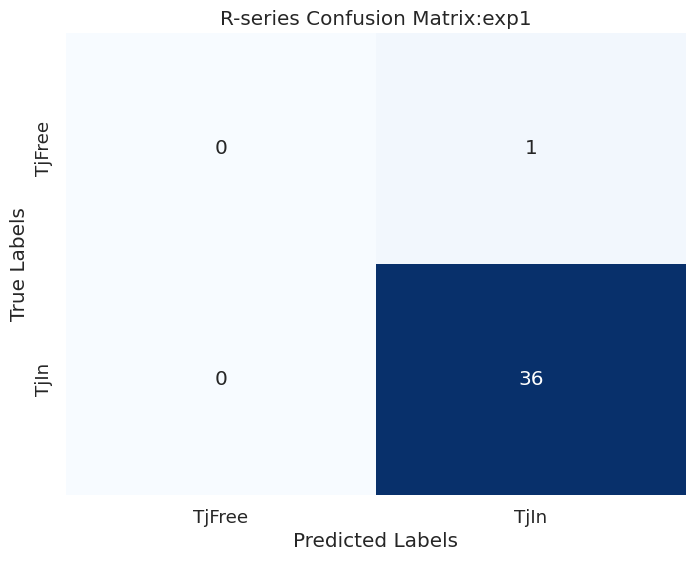


===== exp1_R-series Metrics =====
Accuracy: 0.97
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 36/36 correct (100.00%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 21.14it/s]


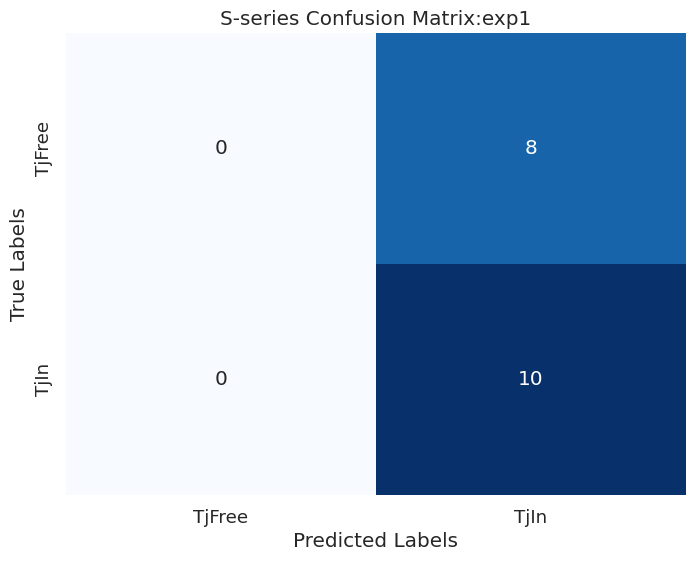


===== exp1_S-series Metrics =====
Accuracy: 0.56
Precision: 0.56
Recall: 1.00
F1 Score: 0.71

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/8 correct (0.00%)
TJ In: 10/10 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 23.00it/s]


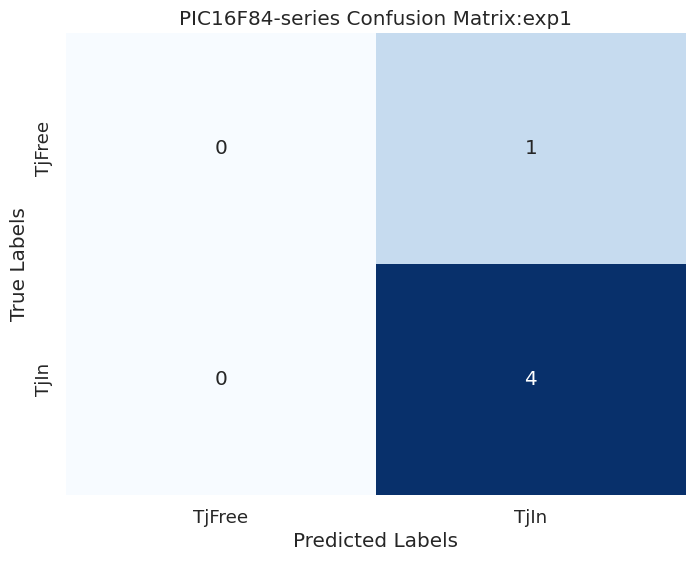


===== exp1_PIC16F84-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 16.00it/s]


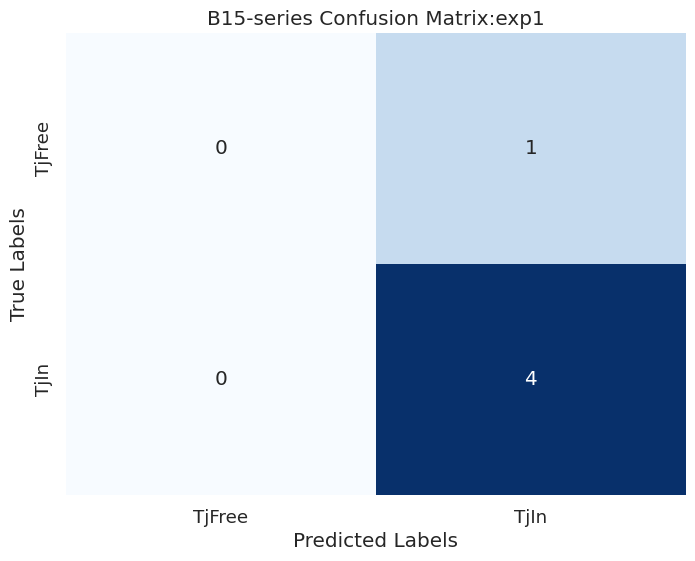


===== exp1_B15-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 81.33it/s]


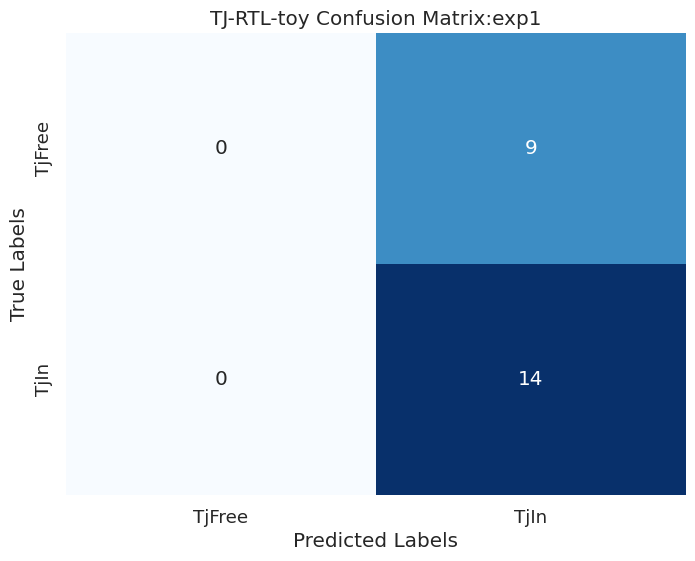


===== exp1_TJ-RTL-toy Metrics =====
Accuracy: 0.61
Precision: 0.61
Recall: 1.00
F1 Score: 0.76

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/9 correct (0.00%)
TJ In: 14/14 correct (100.00%)

Predictions log saved to: results/exp1/exp1_TJ-RTL-toy_predictions.csv


In [ ]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
]

evaluate_multiple_series(
    exp_name="exp1",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("hw2vec/assets/pretrained_DFG_TJ_RTL/model.pth"),
    config_path="hw2vec/assets/pretrained_DFG_TJ_RTL/model.cfg"
)

## Exp2

In [8]:
# training command
# python -m hw2vec.examples.use_case_2 --raw_dataset_path Datasets/TJ-RTL-toy --data_pkl_path data_pickles/gh-data.pkl  --graph_type DFG --device cuda --yaml_path yaml_files/example_gnn4tj.yaml  --model_save_path trained_models/ --model_name gh_data_model

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 59.31it/s]


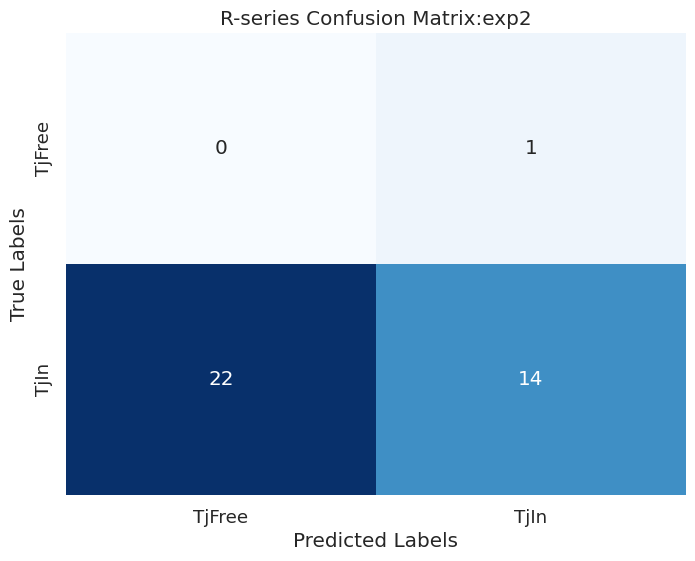


===== exp2_R-series Metrics =====
Accuracy: 0.38
Precision: 0.93
Recall: 0.39
F1 Score: 0.55

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 14/36 correct (38.89%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 23.91it/s]


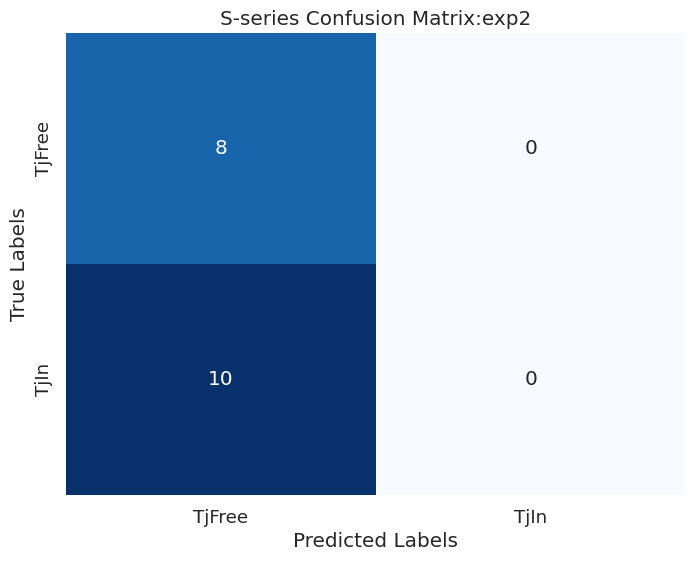


===== exp2_S-series Metrics =====
Accuracy: 0.44
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/8 correct (100.00%)
TJ In: 0/10 correct (0.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 59.38it/s]


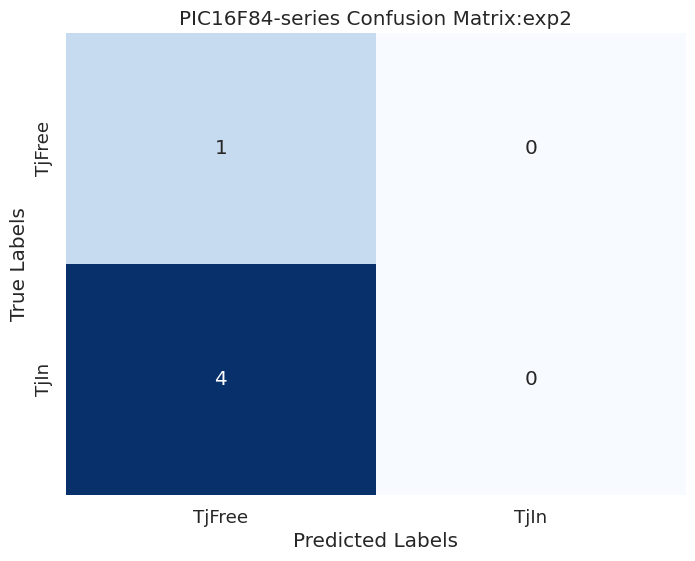


===== exp2_PIC16F84-series Metrics =====
Accuracy: 0.20
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 1/1 correct (100.00%)
TJ In: 0/4 correct (0.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 27.16it/s]


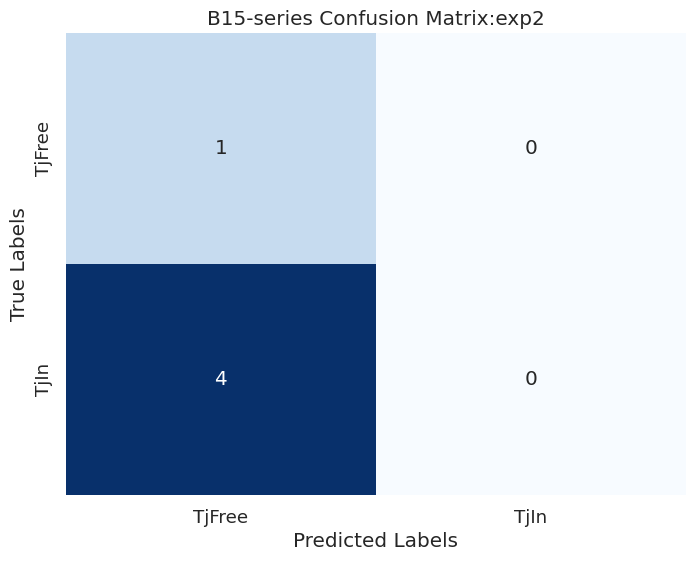


===== exp2_B15-series Metrics =====
Accuracy: 0.20
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 1/1 correct (100.00%)
TJ In: 0/4 correct (0.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 60.79it/s]


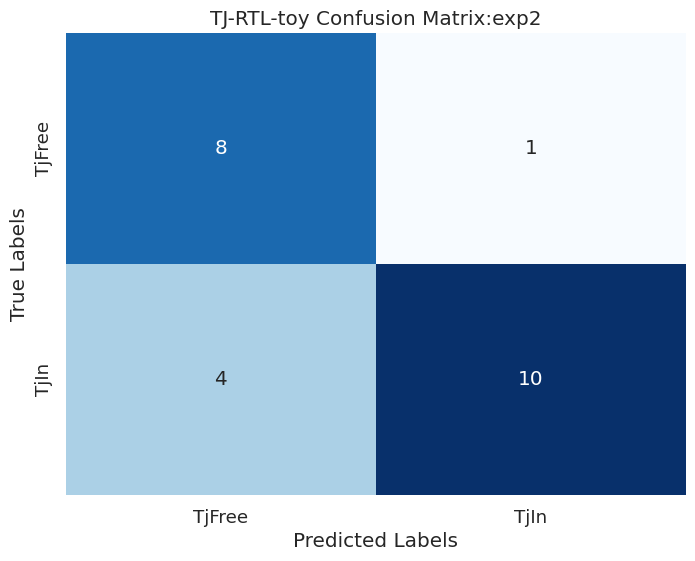


===== exp2_TJ-RTL-toy Metrics =====
Accuracy: 0.78
Precision: 0.91
Recall: 0.71
F1 Score: 0.80

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/9 correct (88.89%)
TJ In: 10/14 correct (71.43%)

Predictions log saved to: results/exp2/exp2_TJ-RTL-toy_predictions.csv


In [9]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
]

evaluate_multiple_series(
    exp_name="exp2",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/gh_data_model_archived.pth"),
    config_path="trained_models/gh_data_model_archived.json"
)

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 59.20it/s]


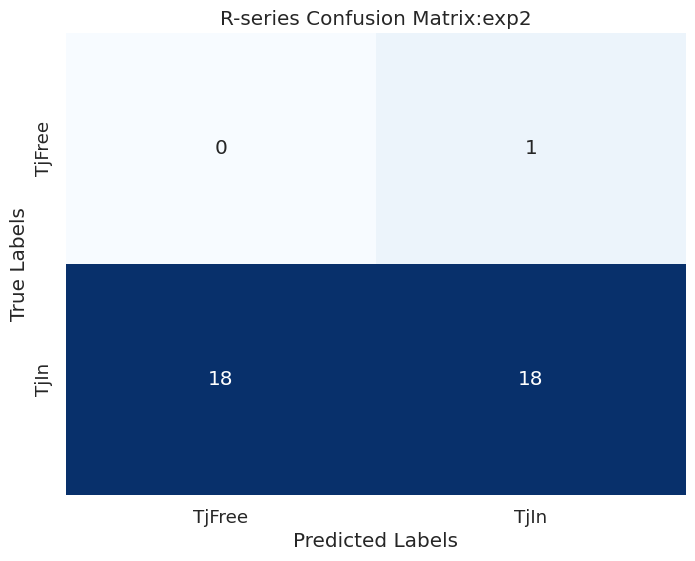


===== exp2_R-series Metrics =====
Accuracy: 0.49
Precision: 0.95
Recall: 0.50
F1 Score: 0.65

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 18/36 correct (50.00%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 24.82it/s]


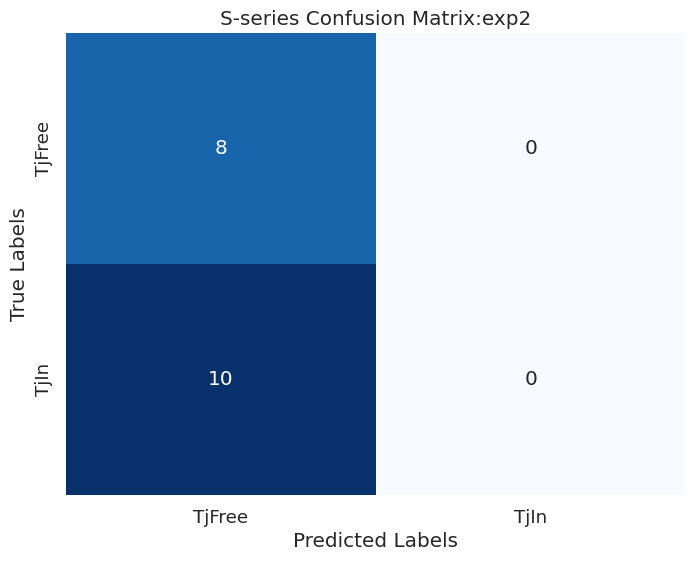


===== exp2_S-series Metrics =====
Accuracy: 0.44
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/8 correct (100.00%)
TJ In: 0/10 correct (0.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 52.71it/s]


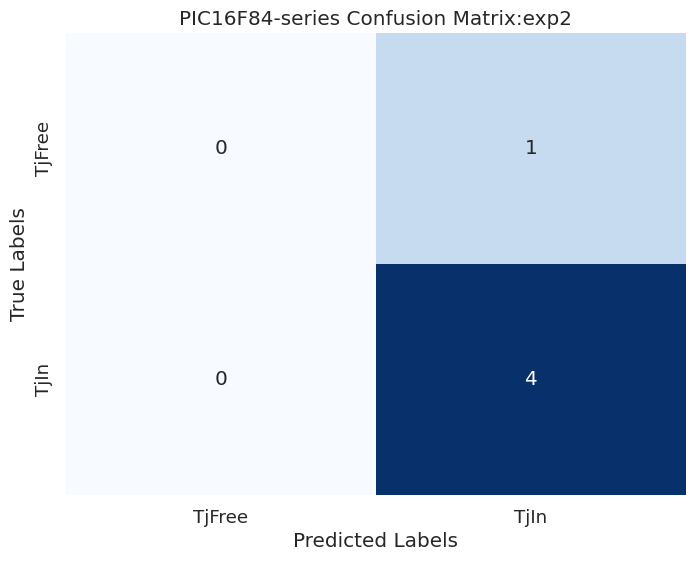


===== exp2_PIC16F84-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 28.12it/s]


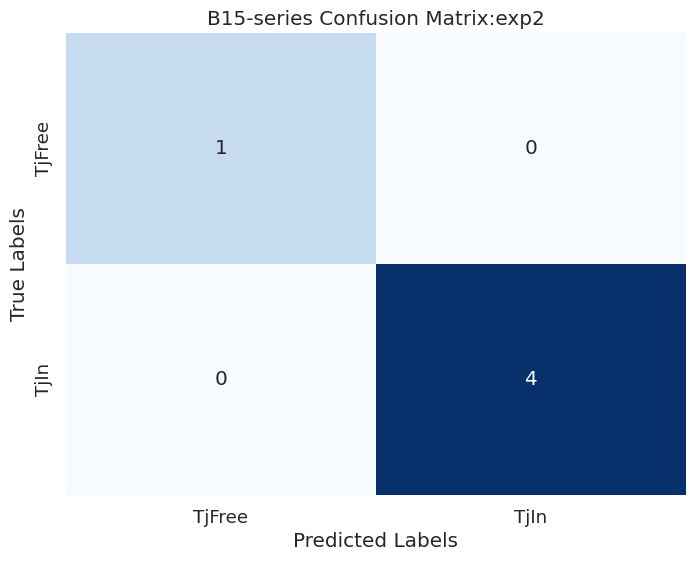


===== exp2_B15-series Metrics =====
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 1/1 correct (100.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 57.63it/s]


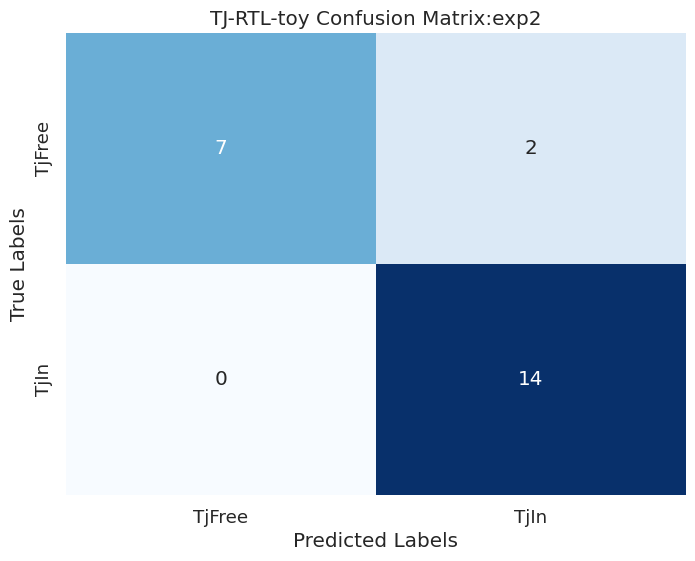


===== exp2_TJ-RTL-toy Metrics =====
Accuracy: 0.91
Precision: 0.88
Recall: 1.00
F1 Score: 0.93

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 7/9 correct (77.78%)
TJ In: 14/14 correct (100.00%)

Predictions log saved to: results/exp2/exp2_TJ-RTL-toy_predictions.csv


In [10]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
]

evaluate_multiple_series(
    exp_name="exp2",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/gh_data_model_best.pth"),
    config_path="trained_models/gh_data_model_best.json"
)

## Exp 3

In [11]:
# training command
# python -m hw2vec.examples.use_case_2 --raw_dataset_path Datasets/S-seriesfinal/S-series --data_pkl_path data_pickles/s-series.pkl  --graph_type DFG --device cuda --yaml_path yaml_files/example_gnn4tj.yaml  --model_save_path trained_models/ --model_name s_series_model

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 57.74it/s]


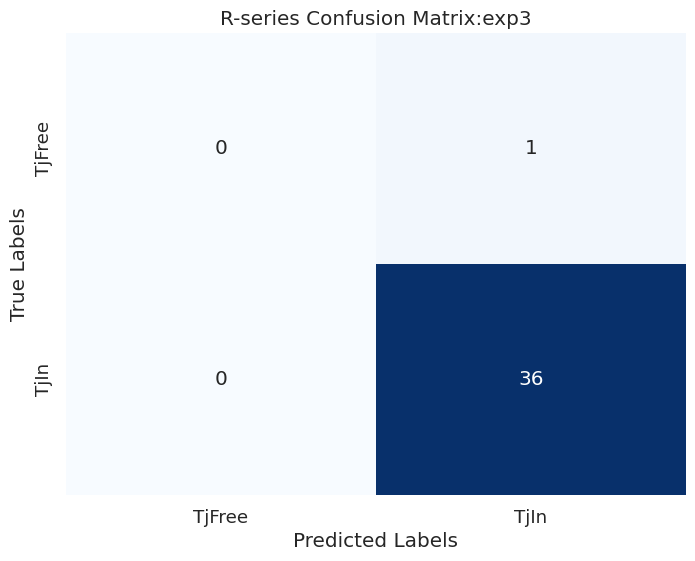


===== exp3_R-series Metrics =====
Accuracy: 0.97
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 36/36 correct (100.00%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 25.08it/s]


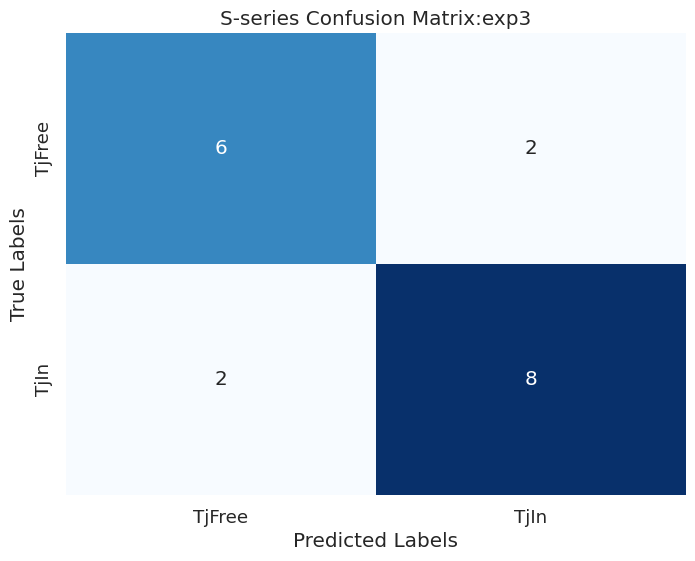


===== exp3_S-series Metrics =====
Accuracy: 0.78
Precision: 0.80
Recall: 0.80
F1 Score: 0.80

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 6/8 correct (75.00%)
TJ In: 8/10 correct (80.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 55.55it/s]


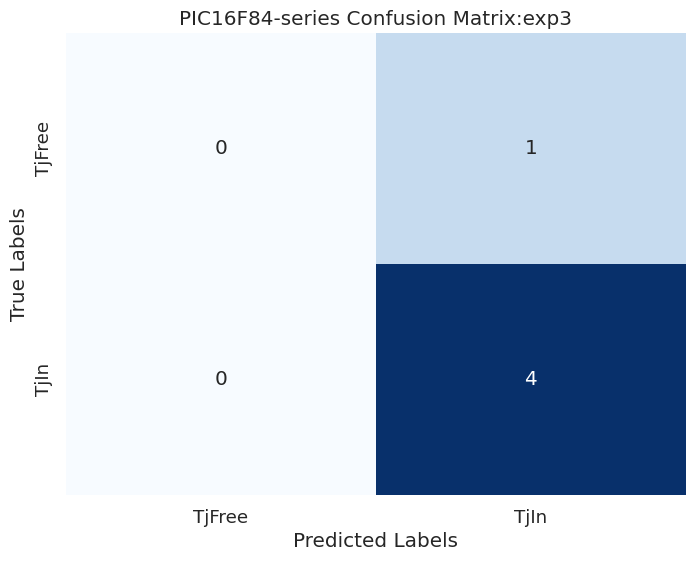


===== exp3_PIC16F84-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 27.48it/s]


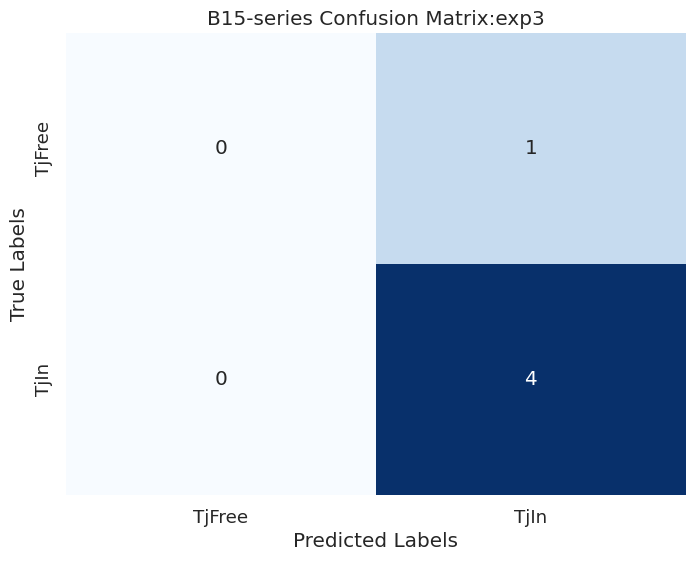


===== exp3_B15-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 60.19it/s]


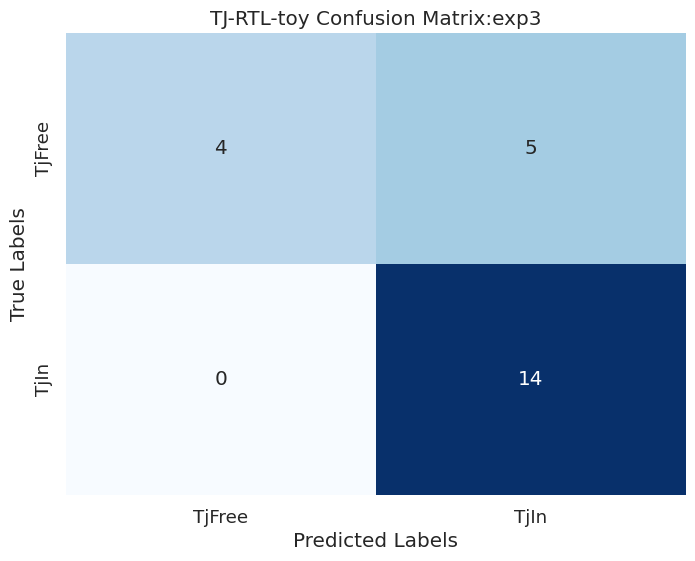


===== exp3_TJ-RTL-toy Metrics =====
Accuracy: 0.78
Precision: 0.74
Recall: 1.00
F1 Score: 0.85

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 4/9 correct (44.44%)
TJ In: 14/14 correct (100.00%)

Predictions log saved to: results/exp3/exp3_TJ-RTL-toy_predictions.csv


In [12]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
]

evaluate_multiple_series(
    exp_name="exp3",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/s_series_model_best_archived.pth"),
    config_path="trained_models/s_series_model_best_archived.json"
)

## Exp5

In [13]:
# training command
# python -m hw2vec.examples.use_case_2 --raw_dataset_path Datasets/Consolidated-data --data_pkl_path data_pickles/consolidated-data.pkl  --graph_type DFG --device cuda --yaml_path yaml_files/example_gnn4tj.yaml  --model_save_path trained_models/ --model_name consolidated_data_model

In [5]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
    Path("Datasets/Consolidated-data"),
]

evaluate_multiple_series(
    exp_name="exp5",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/consolidated_data_model_best.pth"),
    config_path="trained_models/consolidated_data_model_best.json"
)

Processing TJFree:   0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: Model path does not exist

## Exp6

In [ ]:
# python -m hw2vec.examples.use_case_2 --raw_dataset_path Datasets/DOS --data_pkl_path data_pickles/DOS.pkl  --graph_type DFG --device cuda --yaml_path yaml_files/example_gnn4tj.yaml  --model_save_path trained_models/ --model_name DOS_model

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 57.86it/s]


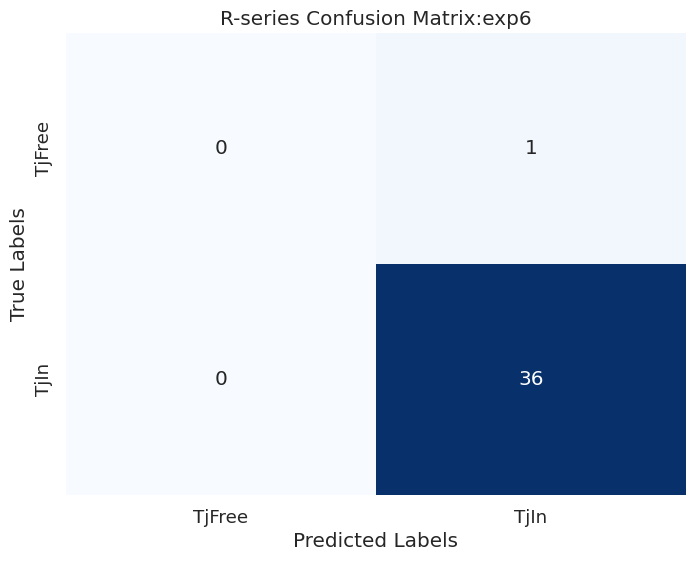


===== exp6_R-series Metrics =====
Accuracy: 0.97
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 36/36 correct (100.00%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 22.79it/s]


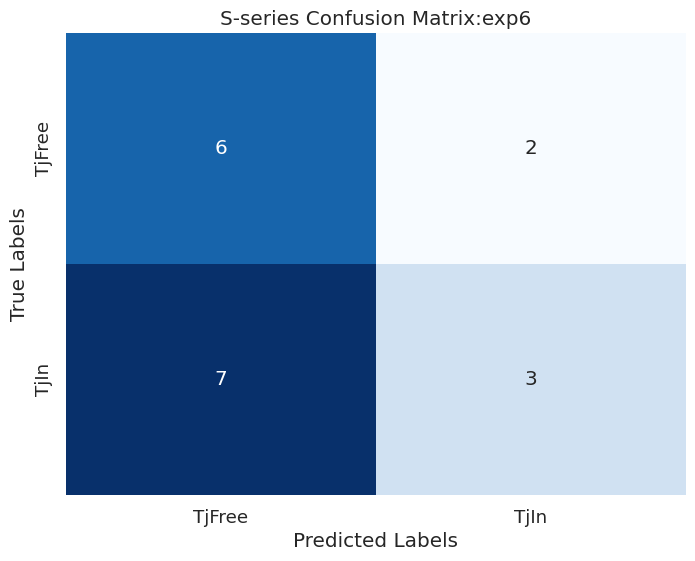


===== exp6_S-series Metrics =====
Accuracy: 0.50
Precision: 0.60
Recall: 0.30
F1 Score: 0.40

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 6/8 correct (75.00%)
TJ In: 3/10 correct (30.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 54.77it/s]


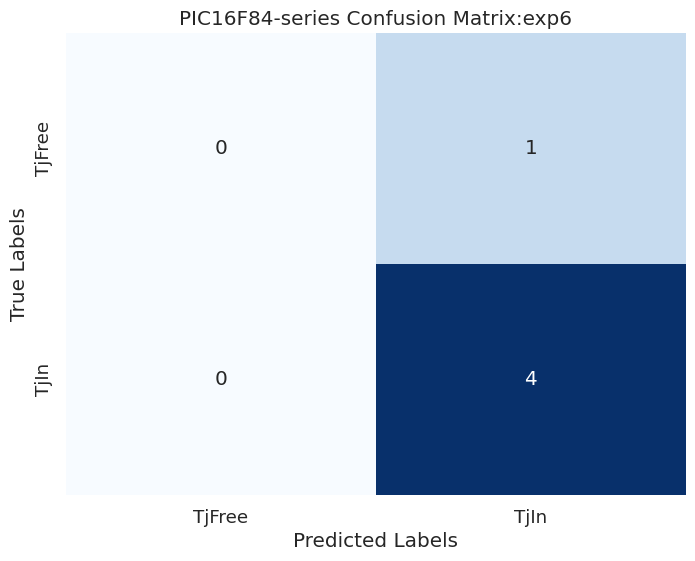


===== exp6_PIC16F84-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 27.38it/s]


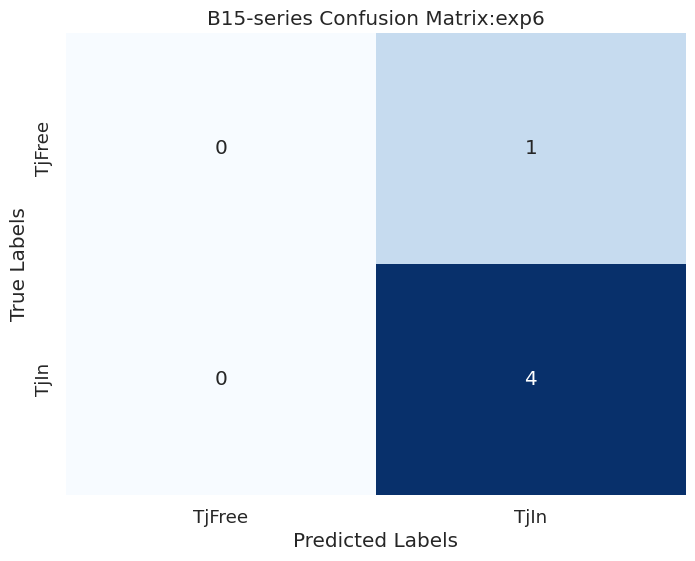


===== exp6_B15-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 52.95it/s]


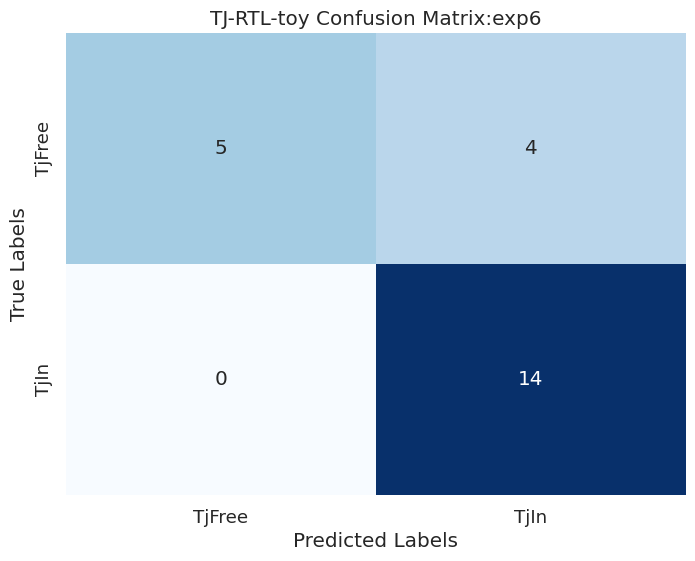


===== exp6_TJ-RTL-toy Metrics =====
Accuracy: 0.83
Precision: 0.78
Recall: 1.00
F1 Score: 0.88

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 5/9 correct (55.56%)
TJ In: 14/14 correct (100.00%)


Processing TJIn: 100%|██████████| 50/50 [00:01<00:00, 42.49it/s]


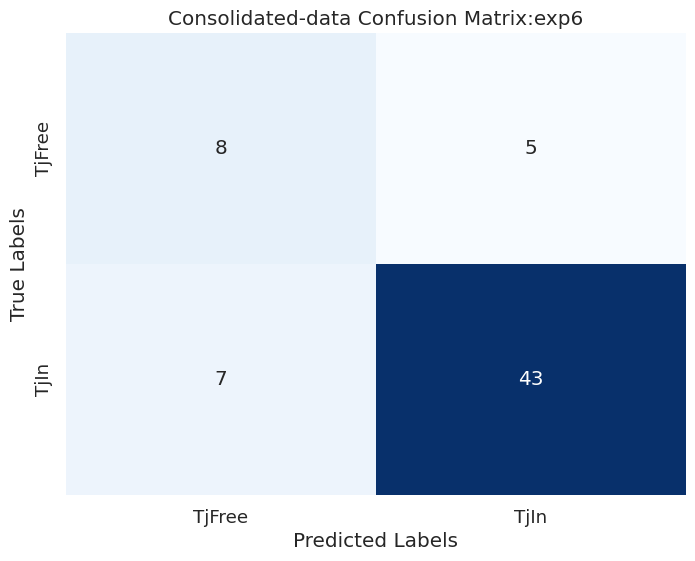


===== exp6_Consolidated-data Metrics =====
Accuracy: 0.81
Precision: 0.90
Recall: 0.86
F1 Score: 0.88

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/13 correct (61.54%)
TJ In: 43/50 correct (86.00%)


Processing TJIn: 100%|██████████| 26/26 [00:00<00:00, 35.81it/s]


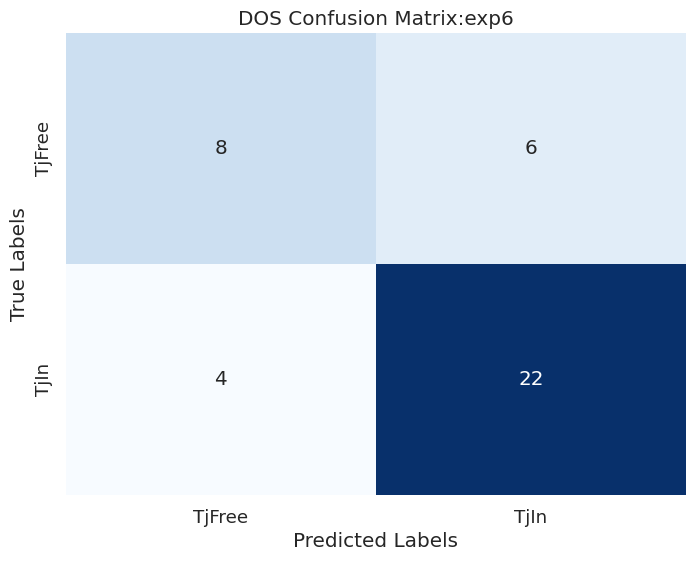


===== exp6_DOS Metrics =====
Accuracy: 0.75
Precision: 0.79
Recall: 0.85
F1 Score: 0.81

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/14 correct (57.14%)
TJ In: 22/26 correct (84.62%)

Predictions log saved to: results/exp6/exp6_DOS_predictions.csv


In [ ]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
    Path("Datasets/Consolidated-data"),
    Path("Datasets/DOS"),
]

evaluate_multiple_series(
    exp_name="exp6",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/DOS_model_best.pth"),
    config_path="trained_models/DOS_model_best.json"
)

## Exp 9

Processing TJIn: 100%|██████████| 36/36 [00:00<00:00, 62.95it/s]


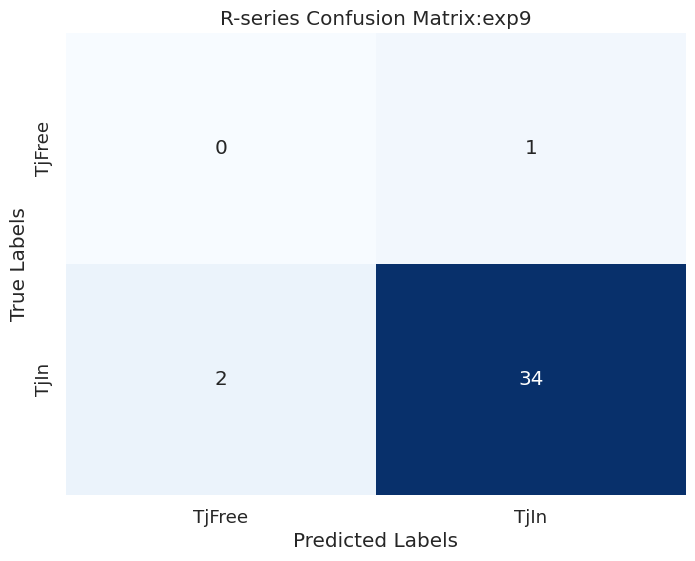


===== exp9_R-series Metrics =====
Accuracy: 0.92
Precision: 0.97
Recall: 0.94
F1 Score: 0.96

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 34/36 correct (94.44%)


Processing TJIn: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s]


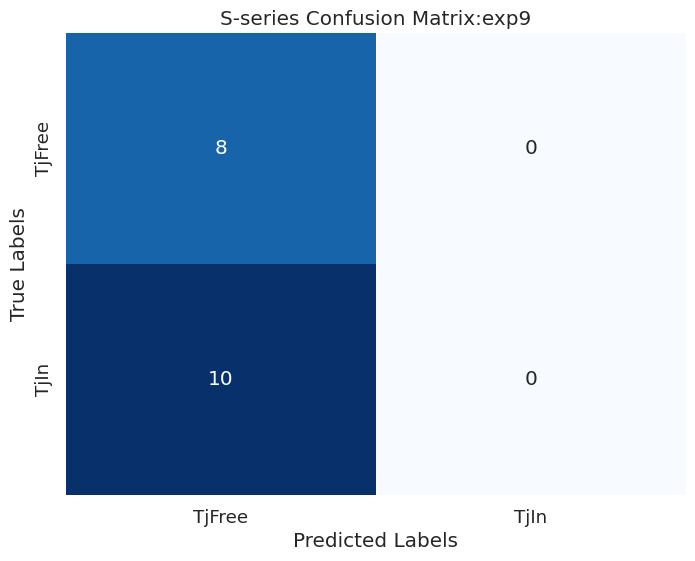


===== exp9_S-series Metrics =====
Accuracy: 0.44
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/8 correct (100.00%)
TJ In: 0/10 correct (0.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 46.43it/s]


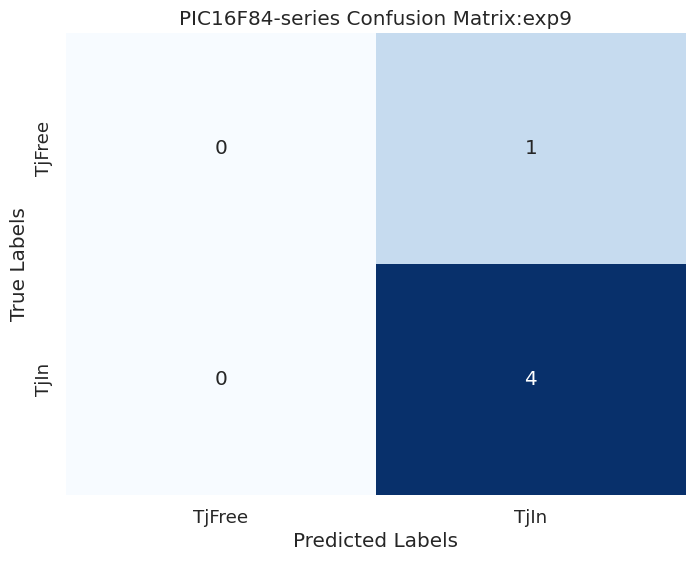


===== exp9_PIC16F84-series Metrics =====
Accuracy: 0.80
Precision: 0.80
Recall: 1.00
F1 Score: 0.89

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/1 correct (0.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 4/4 [00:00<00:00, 25.08it/s]


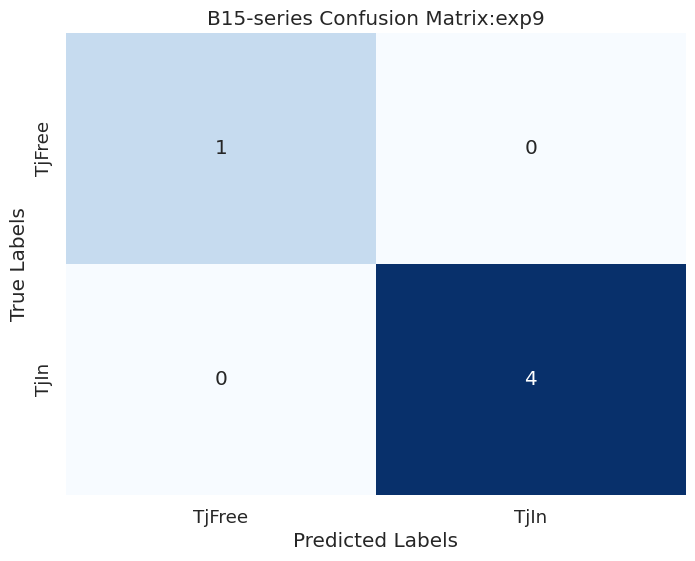


===== exp9_B15-series Metrics =====
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 1/1 correct (100.00%)
TJ In: 4/4 correct (100.00%)


Processing TJIn: 100%|██████████| 14/14 [00:00<00:00, 87.62it/s]


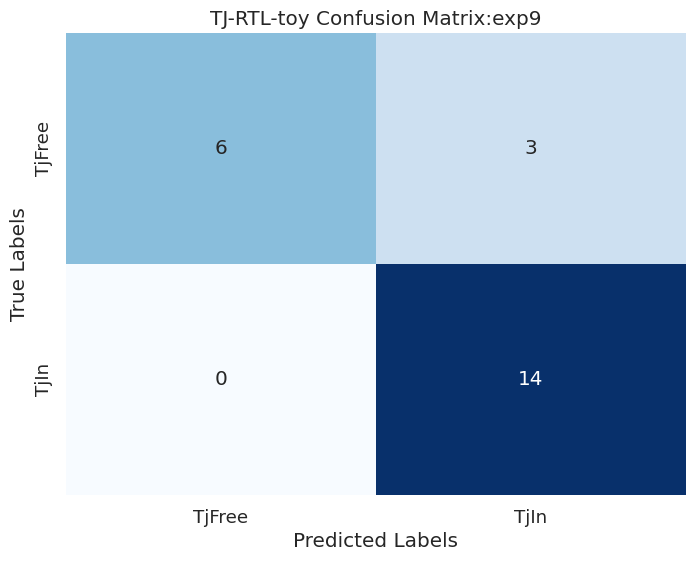


===== exp9_TJ-RTL-toy Metrics =====
Accuracy: 0.87
Precision: 0.82
Recall: 1.00
F1 Score: 0.90

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 6/9 correct (66.67%)
TJ In: 14/14 correct (100.00%)


Processing TJIn: 100%|██████████| 50/50 [00:00<00:00, 56.97it/s]


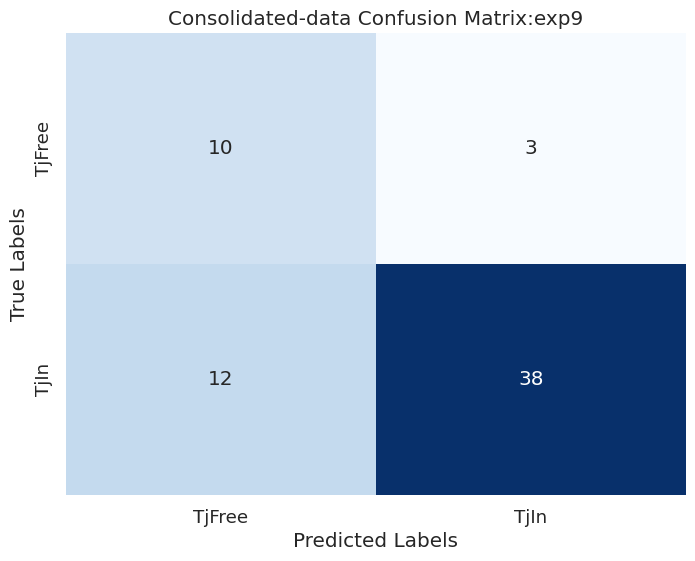


===== exp9_Consolidated-data Metrics =====
Accuracy: 0.76
Precision: 0.93
Recall: 0.76
F1 Score: 0.84

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 10/13 correct (76.92%)
TJ In: 38/50 correct (76.00%)


Processing TJFree:   0%|          | 0/28 [00:00<?, ?it/s]

Datasets/DOS/TjFree/s38584 copy/topModule.v , 52153 , 63291 , 25.23406195640564


Processing TJFree:  11%|█         | 3/28 [00:29<03:47,  9.09s/it]

Datasets/DOS/TjFree/RC6 copy/topModule.v , 2411 , 2716 , 3.472291946411133


Processing TJFree:  18%|█▊        | 5/28 [00:32<01:52,  4.89s/it]

Datasets/DOS/TjFree/PIC16F84 copy/topModule.v , 2541 , 3576 , 2.6265950202941895
Datasets/DOS/TjFree/s35932 copy/topModule.v , 40316 , 48080 , 20.58914017677307


Processing TJFree:  25%|██▌       | 7/28 [00:53<02:34,  7.37s/it]

Datasets/DOS/TjFree/s38417 copy/topModule.v , 45904 , 56073 , 22.964855670928955


Processing TJFree:  54%|█████▎    | 15/28 [01:18<00:43,  3.33s/it]

Datasets/DOS/TjFree/xtea copy/topModule.v , 1830 , 2170 , 1.2162988185882568


Processing TJFree:  61%|██████    | 17/28 [01:19<00:27,  2.51s/it]

Datasets/DOS/TjFree/syncRAM copy/topModule.v , 32 , 32 , 0.7250847816467285


Processing TJFree:  68%|██████▊   | 19/28 [01:20<00:17,  1.93s/it]

Datasets/DOS/TjFree/RS232 copy/topModule.v , 690 , 833 , 0.9263789653778076


Processing TJFree:  71%|███████▏  | 20/28 [01:20<00:13,  1.72s/it]

Datasets/DOS/TjFree/spi_master copy/topModule.v , 144 , 195 , 0.6728765964508057


Processing TJFree:  82%|████████▏ | 23/28 [01:21<00:05,  1.09s/it]

Datasets/DOS/TjFree/vga copy/topModule.v , 41 , 46 , 0.6461095809936523
Datasets/DOS/TjFree/b15 copy/topModule.v , 35806 , 44259 , 17.811745166778564


Processing TJFree:  86%|████████▌ | 24/28 [01:39<00:15,  3.97s/it]

Datasets/DOS/TjFree/s15850 copy/topModule.v , 16664 , 19999 , 9.683714628219604


Processing TJFree:  93%|█████████▎| 26/28 [01:50<00:08,  4.19s/it]

Datasets/DOS/TjFree/det_1011 copy/topModule.v , 71 , 63 , 0.7435989379882812


Processing TJFree: 100%|██████████| 28/28 [01:55<00:00,  4.11s/it]


Datasets/DOS/TjFree/RC5 copy/topModule.v , 2180 , 2463 , 4.2885966300964355


Processing TJIn: 100%|██████████| 26/26 [00:01<00:00, 17.92it/s]


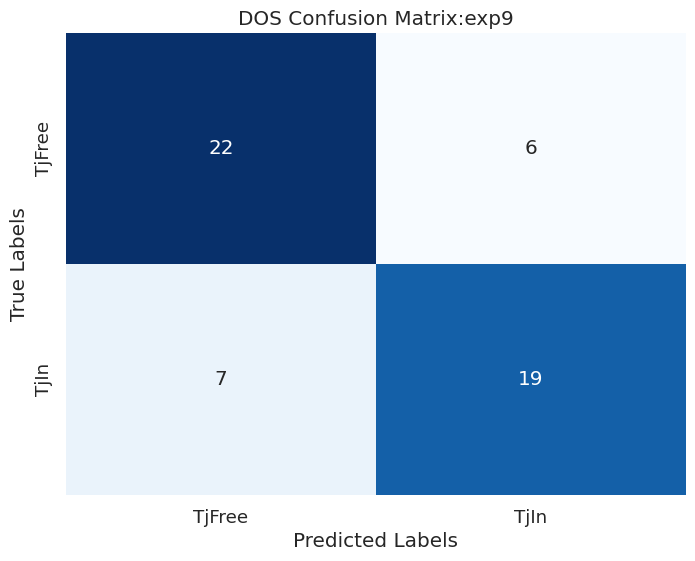


===== exp9_DOS Metrics =====
Accuracy: 0.76
Precision: 0.76
Recall: 0.73
F1 Score: 0.75

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 22/28 correct (78.57%)
TJ In: 19/26 correct (73.08%)

Predictions log saved to: results/exp9/exp9_DOS_predictions.csv


In [10]:
series_paths = [
    Path("Datasets/R-seriesfinal/R-series"),
    Path("Datasets/S-seriesfinal/S-series"),
    Path("Datasets/PIC16F84-seriesfinal/PIC16F84-series"),
    Path("Datasets/B15-seriesfinal/B15-series"),
    Path("Datasets/TJ-RTL-toy"),
    Path("Datasets/Consolidated-data"),
    Path("Datasets/DOS"),
]

evaluate_multiple_series(
    exp_name="exp9",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/DOS_copy_model_best.pth"),
    config_path="trained_models/DOS_copy_model_best.json"
)

# Inference on test datasets exclusive

### Easha

## GH Test

Processing TJIn: 100%|██████████| 40/40 [00:00<00:00, 48.90it/s]


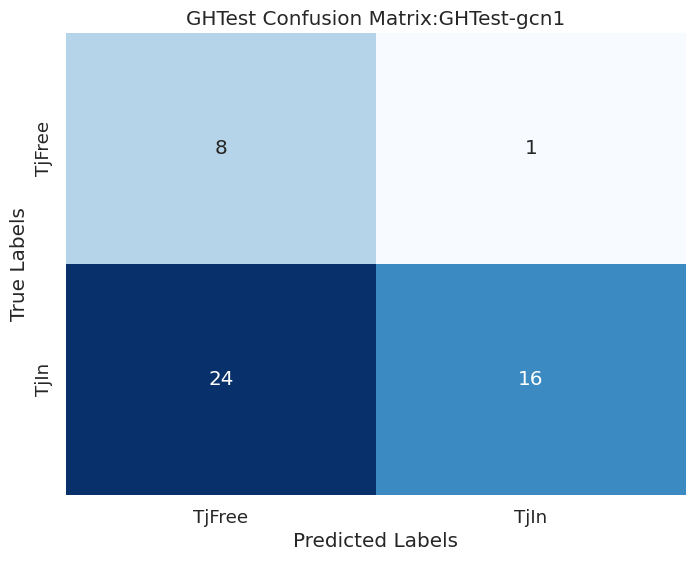


===== GHTest-gcn1_GHTest Metrics =====
Accuracy: 0.49
Precision: 0.94
Recall: 0.40
F1 Score: 0.56

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 8/9 correct (88.89%)
TJ In: 16/40 correct (40.00%)

Predictions log saved to: results/GHTest-gcn1/GHTest-gcn1_GHTest_predictions.csv


In [35]:
series_paths = [
    Path("Datasets/GHTest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="GHTest-gcn1",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/gh_data_model.pth"),
    config_path="trained_models/gh_data_model.json"
)

## STest

Processing TJIn: 100%|██████████| 44/44 [00:00<00:00, 75.99it/s]


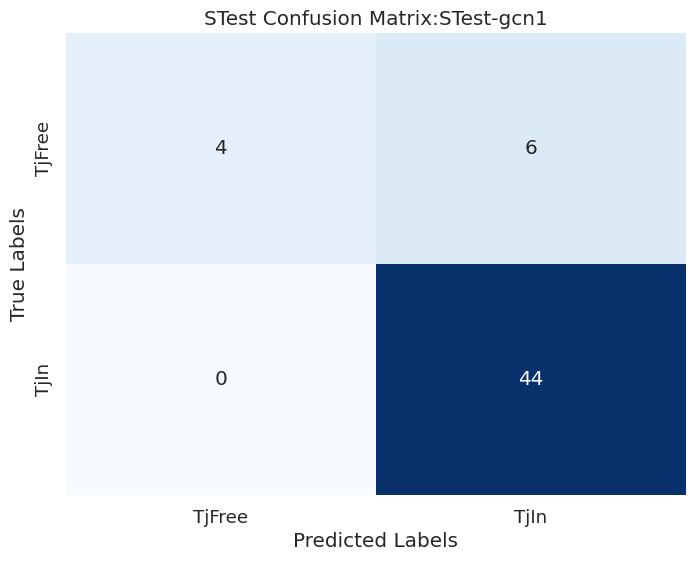


===== STest-gcn1_STest Metrics =====
Accuracy: 0.89
Precision: 0.88
Recall: 1.00
F1 Score: 0.94

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 4/10 correct (40.00%)
TJ In: 44/44 correct (100.00%)

Predictions log saved to: results/STest-gcn1/STest-gcn1_STest_predictions.csv


In [36]:
series_paths = [
    Path("Datasets/STest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="STest-gcn1",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/s_series_model_best_archived.pth"),
    config_path="trained_models/s_series_model_best_archived.json"
)

## DOSTest

Processing TJIn: 100%|██████████| 29/29 [00:00<00:00, 65.18it/s]


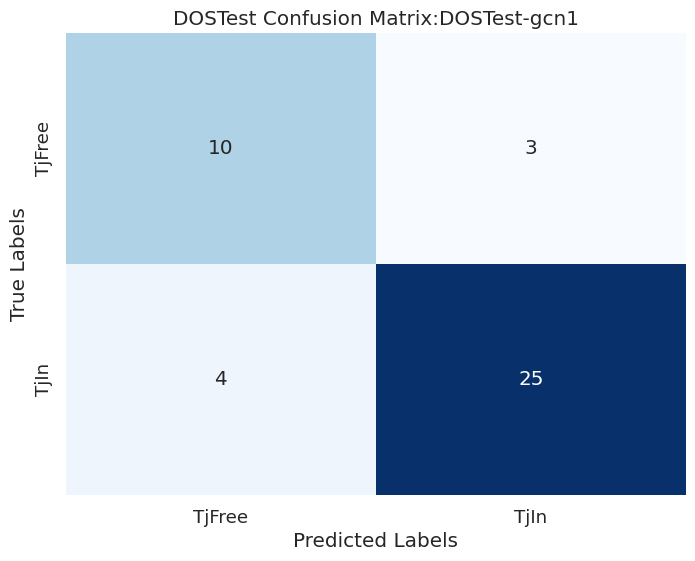


===== DOSTest-gcn1_DOSTest Metrics =====
Accuracy: 0.83
Precision: 0.89
Recall: 0.86
F1 Score: 0.88

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 10/13 correct (76.92%)
TJ In: 25/29 correct (86.21%)

Predictions log saved to: results/DOSTest-gcn1/DOSTest-gcn1_DOSTest_predictions.csv


In [6]:
series_paths = [
    Path("Datasets/DOSTest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="DOSTest-gcn1",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/DOS_copy_model_best_test.pth"),
    config_path="trained_models/DOS_copy_model_best_test.json"
)

## ConsolidatedTest

Processing TJIn: 100%|██████████| 50/50 [00:00<00:00, 63.05it/s]


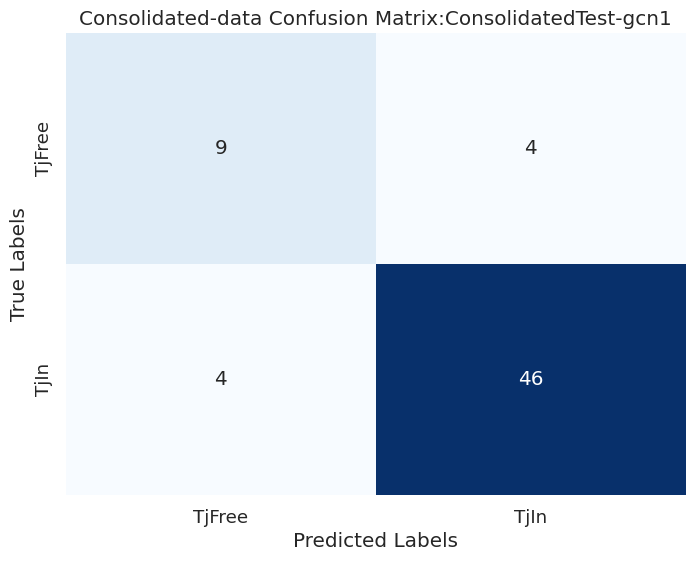


===== ConsolidatedTest-gcn1_Consolidated-data Metrics =====
Accuracy: 0.87
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 9/13 correct (69.23%)
TJ In: 46/50 correct (92.00%)

Predictions log saved to: results/ConsolidatedTest-gcn1/ConsolidatedTest-gcn1_Consolidated-data_predictions.csv


In [38]:
series_paths = [
    Path("Datasets/Consolidated-data"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="ConsolidatedTest-gcn1",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("trained_models/consolidated_data_model_archived.pth"),
    config_path="trained_models/consolidated_data_model_archived.json"
)

### Mustafa

#### agcn

## ConsolidatedTest-agcn

Processing TJIn: 100%|██████████| 50/50 [00:00<00:00, 53.94it/s]


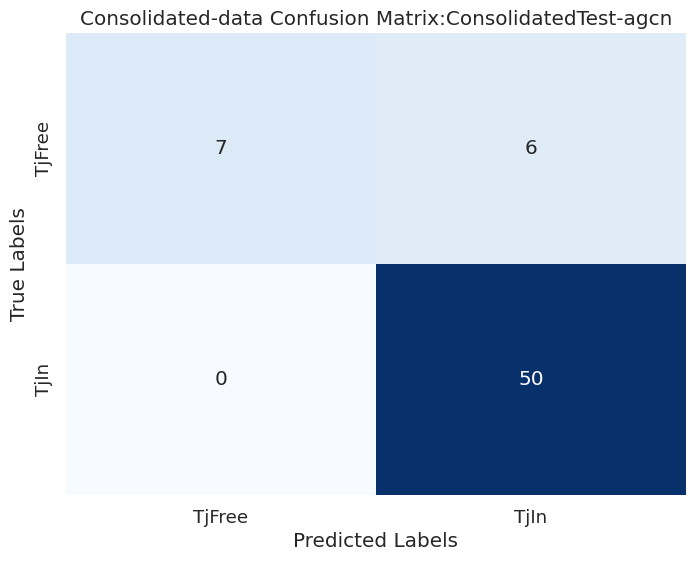


===== ConsolidatedTest-agcn_Consolidated-data Metrics =====
Accuracy: 0.90
Precision: 0.89
Recall: 1.00
F1 Score: 0.94

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 7/13 correct (53.85%)
TJ In: 50/50 correct (100.00%)

Predictions log saved to: results/ConsolidatedTest-agcn/ConsolidatedTest-agcn_Consolidated-data_predictions.csv


In [5]:
series_paths = [
    Path("Datasets/Consolidated-data"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="ConsolidatedTest-agcn",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/agnn/Combined_Dataset/400_0.001.pth"),
    config_path="MustafaModels/Models/agnn/Combined_Dataset/400_0.001.json"
)

## GHTest-agcn

Processing TJIn: 100%|██████████| 40/40 [00:00<00:00, 62.66it/s]


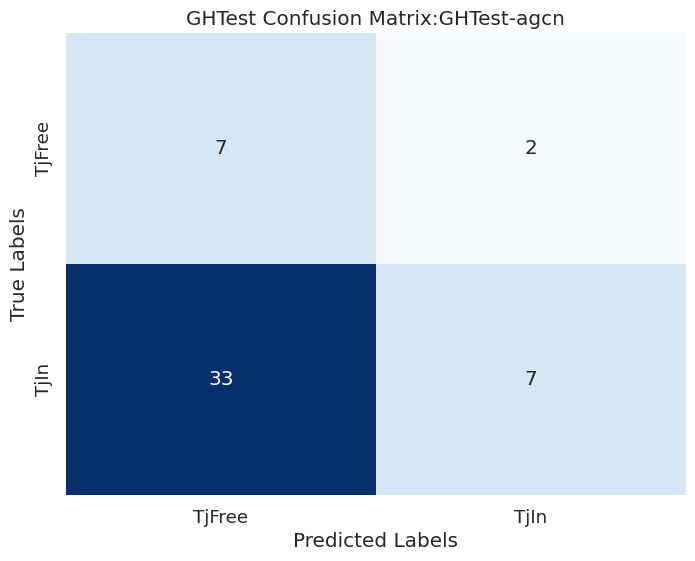


===== GHTest-agcn_GHTest Metrics =====
Accuracy: 0.29
Precision: 0.78
Recall: 0.17
F1 Score: 0.29

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 7/9 correct (77.78%)
TJ In: 7/40 correct (17.50%)

Predictions log saved to: results/GHTest-agcn/GHTest-agcn_GHTest_predictions.csv


In [7]:
series_paths = [
    Path("Datasets/GHTest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="GHTest-agcn",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/agnn/github_dataset/400_0.001.pth"),
    config_path="MustafaModels/Models/agnn/github_dataset/400_0.001.cfg"
)

## STest-agcn

Processing TJIn: 100%|██████████| 44/44 [00:00<00:00, 102.44it/s]


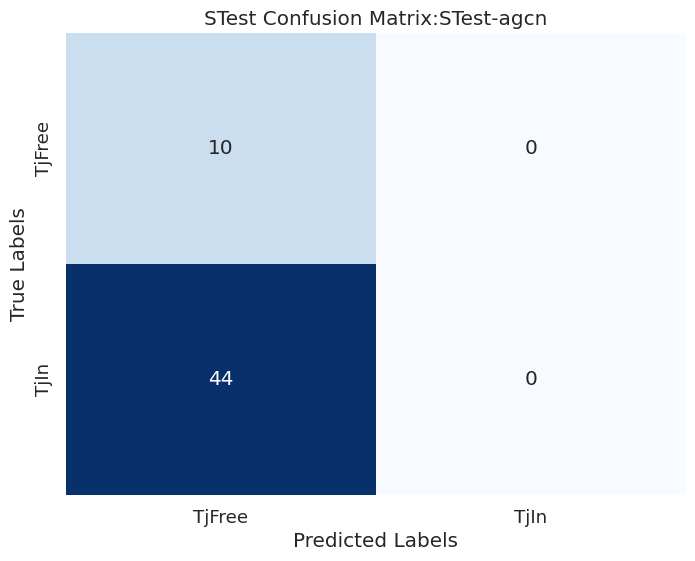


===== STest-agcn_STest Metrics =====
Accuracy: 0.19
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 10/10 correct (100.00%)
TJ In: 0/44 correct (0.00%)

Predictions log saved to: results/STest-agcn/STest-agcn_STest_predictions.csv


In [9]:
series_paths = [
    Path("Datasets/STest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="STest-agcn",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/agnn/S-series/400_0.001.pth"),
    config_path="MustafaModels/Models/agnn/S-series/400_0.001.cfg"
)

#### gin

## ConsolidatedTest-gin

Processing TJIn: 100%|██████████| 50/50 [00:00<00:00, 110.38it/s]


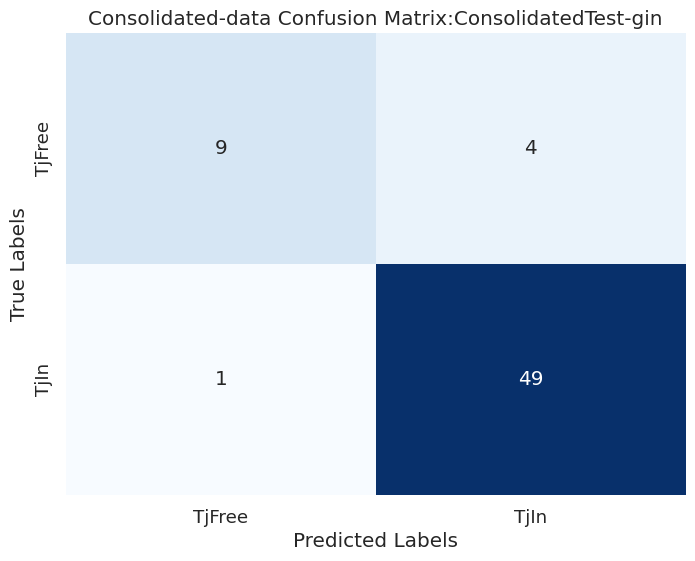


===== ConsolidatedTest-gin_Consolidated-data Metrics =====
Accuracy: 0.92
Precision: 0.92
Recall: 0.98
F1 Score: 0.95

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 9/13 correct (69.23%)
TJ In: 49/50 correct (98.00%)

Predictions log saved to: results/ConsolidatedTest-gin/ConsolidatedTest-gin_Consolidated-data_predictions.csv


In [11]:
series_paths = [
    Path("Datasets/Consolidated-data"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="ConsolidatedTest-gin",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gin/Combined_Dataset/400_0.001.pth"),
    config_path="MustafaModels/Models/gin/Combined_Dataset/400_0.001.cfg"
)

## GHTest-gin

Processing TJIn: 100%|██████████| 40/40 [00:00<00:00, 93.19it/s]


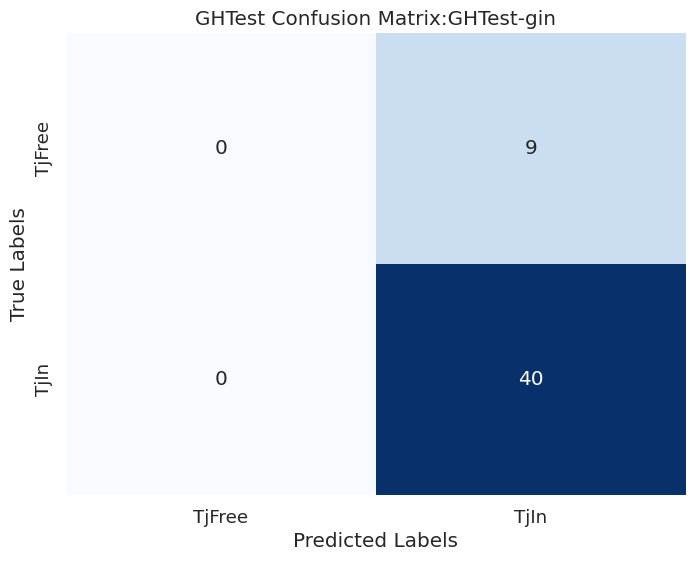


===== GHTest-gin_GHTest Metrics =====
Accuracy: 0.82
Precision: 0.82
Recall: 1.00
F1 Score: 0.90

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/9 correct (0.00%)
TJ In: 40/40 correct (100.00%)

Predictions log saved to: results/GHTest-gin/GHTest-gin_GHTest_predictions.csv


In [12]:
series_paths = [
    Path("Datasets/GHTest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="GHTest-gin",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gin/github_dataset/400_0.001.pth"),
    config_path="MustafaModels/Models/gin/github_dataset/400_0.001.cfg"
)

## STest-gin

Processing TJIn: 100%|██████████| 44/44 [00:00<00:00, 117.67it/s]


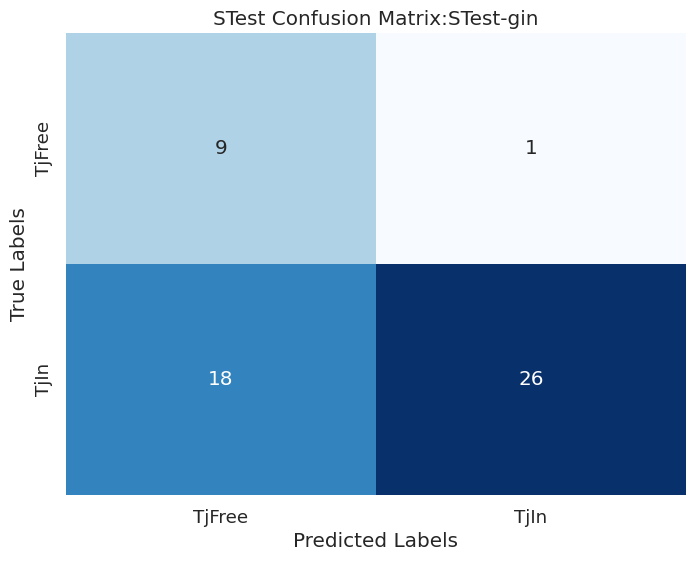


===== STest-gin_STest Metrics =====
Accuracy: 0.65
Precision: 0.96
Recall: 0.59
F1 Score: 0.73

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 9/10 correct (90.00%)
TJ In: 26/44 correct (59.09%)

Predictions log saved to: results/STest-gin/STest-gin_STest_predictions.csv


In [14]:
series_paths = [
    Path("Datasets/STest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="STest-gin",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gin/S-series/400_0.001.pth"),
    config_path="MustafaModels/Models/gin/S-series/400_0.001.cfg"
)

#### gcn

## ConsolidatedTest-gcn2

Processing TJIn: 100%|██████████| 50/50 [00:00<00:00, 96.71it/s]


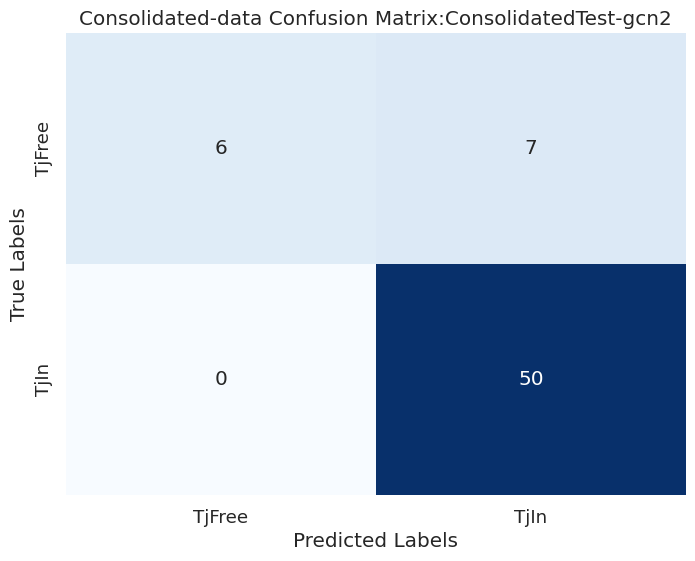


===== ConsolidatedTest-gcn2_Consolidated-data Metrics =====
Accuracy: 0.89
Precision: 0.88
Recall: 1.00
F1 Score: 0.93

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 6/13 correct (46.15%)
TJ In: 50/50 correct (100.00%)

Predictions log saved to: results/ConsolidatedTest-gcn2/ConsolidatedTest-gcn2_Consolidated-data_predictions.csv


In [15]:
series_paths = [
    Path("Datasets/Consolidated-data"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="ConsolidatedTest-gcn2",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gcn/Combined_Dataset/600_0.001.pth"),
    config_path="MustafaModels/Models/gcn/Combined_Dataset/600_0.001.cfg"
)

## GHTest-gcn2

Processing TJIn: 100%|██████████| 40/40 [00:00<00:00, 85.01it/s]


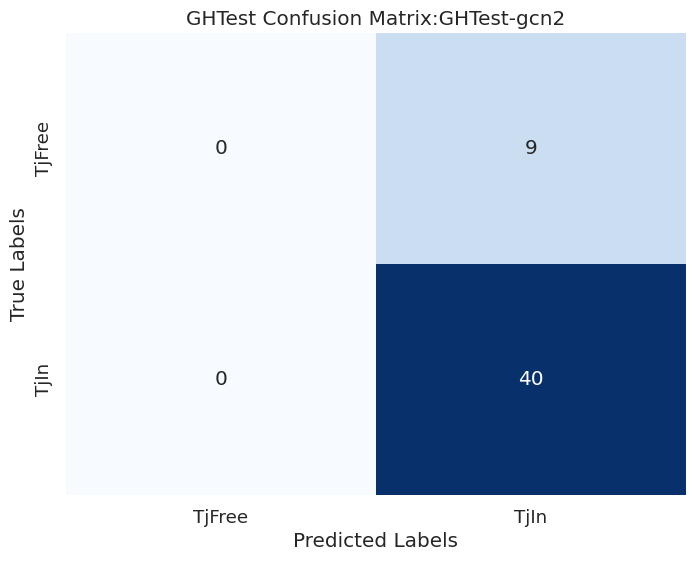


===== GHTest-gcn2_GHTest Metrics =====
Accuracy: 0.82
Precision: 0.82
Recall: 1.00
F1 Score: 0.90

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 0/9 correct (0.00%)
TJ In: 40/40 correct (100.00%)

Predictions log saved to: results/GHTest-gcn2/GHTest-gcn2_GHTest_predictions.csv


In [17]:
series_paths = [
    Path("Datasets/GHTest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="GHTest-gcn2",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gcn/github_dataset/400_0.001.pth"),
    config_path="MustafaModels/Models/gcn/github_dataset/400_0.001.cfg"
)

## STest-gcn2

Processing TJIn: 100%|██████████| 44/44 [00:00<00:00, 117.63it/s]


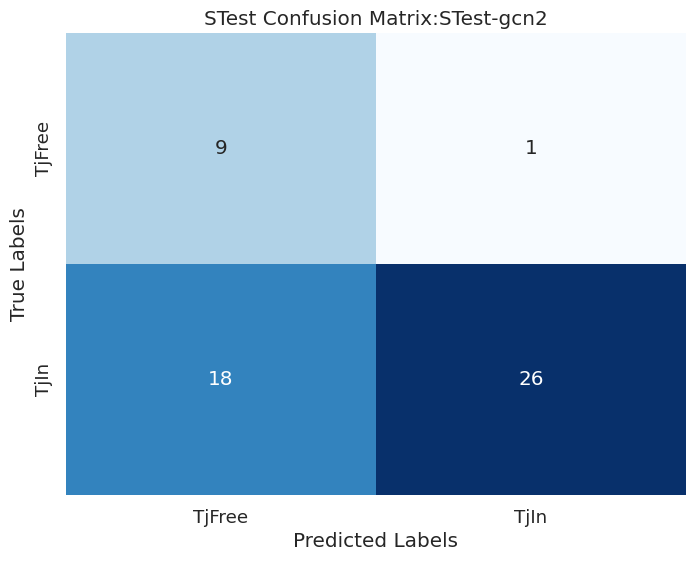


===== STest-gcn2_STest Metrics =====
Accuracy: 0.65
Precision: 0.96
Recall: 0.59
F1 Score: 0.73

===== Errors =====
TjFree Errors: []
TJ In Errors: []

===== Accuracy Stats =====
TjFree: 9/10 correct (90.00%)
TJ In: 26/44 correct (59.09%)

Predictions log saved to: results/STest-gcn2/STest-gcn2_STest_predictions.csv


In [16]:
series_paths = [
    Path("Datasets/STest"),
]

# exp name should not caontain any underscore
evaluate_multiple_series(
    exp_name="STest-gcn2",
    series_paths=series_paths,
    yaml_path="yaml_files/example_gnn4tj.yaml",
    model_path=Path("MustafaModels/Models/gcn/S-series/400_0.001.pth"),
    config_path="MustafaModels/Models/gcn/S-series/400_0.001.cfg"
)

## Inference Demo

In [6]:
import yaml
from hw2vec.hw2vec.hw2graph import *
from hw2vec.hw2vec.graph2vec.models import *
# Define a class to encapsulate the configuration dictionary
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)

# Configuration parameters
yaml_path = 'hw2vec/examples/example_gnn4tj.yaml'
# raw_dataset_path = Path('/home/easha/FYP/hw2vec/assets/datasets/TJ-RTL-toy/TjFree/det_1011') 
raw_dataset_path = Path('/home/easha/FYP/hw2vec/assets/datasets/TJ-RTL-toy/TjIn/PIC16F84-T100') 
verilog_file_path = raw_dataset_path
data_pkl_path = Path('hw2vec/examples/testing.pkl')
graph_type = 'DFG'
device = 'cuda'

with open(yaml_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update config_dict with additional parameters
config_dict.update({
    'raw_dataset_path': str(raw_dataset_path),
    'data_pkl_path': str(data_pkl_path),
    'graph_type': graph_type,
    'device': device
})

config = Config(config_dict)

nx_graphs = []
hw2graph = HW2GRAPH(config)

# Process the single Verilog file
hw_graph = hw2graph.code2graph(verilog_file_path)
nx_graphs.append(hw_graph)

data_proc = DataProcessor(config)
for hw_graph in nx_graphs:
    data_proc.process(hw_graph)
data_proc.cache_graph_data(config.data_pkl_path)
data=data_proc.get_graphs()


def inference(model, data_loader, config):
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(data_loader):
            data = data.to(config.device)  

            output, attn = model.embed_graph(data.x, data.edge_index, data.batch)
            output = model.mlp(output)
            output = F.log_softmax(output, dim=1)

        outputs_tensor = torch.FloatTensor(output.cpu()).detach()
        preds = outputs_tensor.max(1)[1].detach()

    return outputs_tensor, preds

train_loader = DataLoader(data, shuffle=True, batch_size=1)


model_info = [
    {"name": "Model 1: DOS", "model_path": "trained_models/DOS_copy_model_best_test.pth", "config_path": "trained_models/DOS_copy_model_best_test.json"},
    {"name": "Model 2: S-Series", "model_path": "trained_models/s_series_model_best_archived.pth", "config_path": "trained_models/s_series_model_best_archived.json"},
    {"name": "Model 3: Combined", "model_path": "MustafaModels/Models/gin/Combined_Dataset/400_0.001.pth", "config_path": "MustafaModels/Models/gin/Combined_Dataset/400_0.001.cfg"},
    {"name": "Model 4: GH", "model_path": "MustafaModels/Models/gin/github_dataset/400_0.001.pth", "config_path": "MustafaModels/Models/gin/github_dataset/400_0.001.cfg"},
]



trojan_predictions = 0
trojan_free_predictions = 0
trojan_detected_by = []
trojan_free_detected_by = []

for model_data in model_info:
    print(f"--- Inference with {model_data['name']} ---")
    model = GRAPH2VEC(config)
    model_path = Path(model_data["model_path"])
    config_path = Path(model_data["config_path"])

    if model_path.exists() and config_path.exists():
        model.load_model(str(config_path), str(model_path))
        model.to(config.device)
        outputs_tensor, preds = inference(model, train_loader, config)

        if outputs_tensor is not None and preds is not None:
            print(f"Model: {model_data['name']}")
            print(f"Output Tensor: {outputs_tensor}")
            predicted_class = 'TjFree' if preds[0] == 0 else 'TjIn'
            print(f"Predicted Class: {predicted_class}\n")
            if preds[0] == 1:
                trojan_predictions += 1
                trojan_detected_by.append(model_data['name'])
            else:
                trojan_free_predictions += 1
                trojan_free_detected_by.append(model_data['name'])
        else:
            print("Inference failed for this model.\n")
    else:
        print(f"Model or config file not found for {model_data['name']}.\n")

print("\n--- Summary of Predictions ---")
print(f"Number of models predicting Trojan: {trojan_predictions}")
print(f"Models predicting Trojan: {trojan_detected_by}")
print(f"Number of models predicting Trojan Free: {trojan_free_predictions}")
print(f"Models predicting Trojan Free: {trojan_free_detected_by}")

if trojan_predictions == len(model_info):
    print("\nAll models detected it as Trojan.")
elif trojan_free_predictions == len(model_info):
    print("\nAll models detected it as Trojan Free, so it is finally Trojan Free.")
elif trojan_predictions >= 1:
    print("\nAt least one model predicted it as Trojan inserted, so this will be discarded.")

/home/easha/FYP/hw2vec/assets/datasets/TJ-RTL-toy/TjIn/PIC16F84-T100/topModule.v , 2632 , 3692 , 2.5499706268310547
--- Inference with Model 1: DOS ---
Model: Model 1: DOS
Output Tensor: tensor([[-1.2427, -0.3405]])
Predicted Class: TjIn

--- Inference with Model 2: S-Series ---
Model: Model 2: S-Series
Output Tensor: tensor([[-6.5826e+00, -1.3852e-03]])
Predicted Class: TjIn

--- Inference with Model 3: Combined ---
Model: Model 3: Combined
Output Tensor: tensor([[-1.3159e+01, -1.9073e-06]])
Predicted Class: TjIn

--- Inference with Model 4: GH ---
Model: Model 4: GH
Output Tensor: tensor([[-1.2720e+01, -2.9802e-06]])
Predicted Class: TjIn


--- Summary of Predictions ---
Number of models predicting Trojan: 4
Models predicting Trojan: ['Model 1: DOS', 'Model 2: S-Series', 'Model 3: Combined', 'Model 4: GH']
Number of models predicting Trojan Free: 0
Models predicting Trojan Free: []

All models detected it as Trojan.
